In [1]:
import numpy as np
import pandas as pd
import vector
import os
import awkward as ak

vector.register_awkward()

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# mplhep for CMS-style plots
import mplhep as hep
import hist
from coffea.hist.plot import clopper_pearson_interval

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.dpi"] = 400
plt.rcParams["figure.edgecolor"] = "none"

In [13]:
# set up directory to save plots
plot_dir = "../../../plots/MatchingStudy/23Sep19/"
_ = os.system(f"mkdir -p {plot_dir}")

In [14]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "Msd" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [15]:
# match resolved jets to Higgs
# get events and jets
events = pd.read_parquet(
    "/eos/uscms/store/user/cmantill/bbbb/matching/Sep19/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
jets = make_vector(events, "ak4Jet")
gen_higgs = make_vector(events, "GenHiggs")
fjs = make_vector(events, "ak8FatJet")

# get js matched to higgs
h1m2ak4 = (events["ak4JetHiggsMatchIndex"].to_numpy() == 0).sum(axis=1) == 2
h2m2ak4 = (events["ak4JetHiggsMatchIndex"].to_numpy() == 1).sum(axis=1) == 2
event_h1 = events[h1m2ak4]
event_h2 = events[h2m2ak4]

jet_mwh1_idx = event_h1["ak4JetHiggsMatchIndex"] == 0
jet_mwh2_idx = event_h2["ak4JetHiggsMatchIndex"] == 1

jet_mwh1 = jets[h1m2ak4][jet_mwh1_idx]
jet_mwh2 = jets[h2m2ak4][jet_mwh2_idx]

# get higgs that are matched to js
h1_mwj = gen_higgs[h1m2ak4][:, 0]
h2_mwj = gen_higgs[h2m2ak4][:, 1]

# get fjs matched to higgs
h1m1ak8 = (events["ak8FatJetHiggsMatchIndex"].to_numpy() == 0).sum(axis=1) == 1
h2m1ak8 = (events["ak8FatJetHiggsMatchIndex"].to_numpy() == 1).sum(axis=1) == 1
event_h1 = events[h1m1ak8]
event_h2 = events[h2m1ak8]

fj_mwh1_idx = event_h1["ak8FatJetHiggsMatchIndex"] == 0
fj_mwh2_idx = event_h2["ak8FatJetHiggsMatchIndex"] == 1

fj_mwh1 = fjs[h1m1ak8][fj_mwh1_idx]
fj_mwh2 = fjs[h2m1ak8][fj_mwh2_idx]

# get higgs that are matched to js
h1_mwfj = gen_higgs[h1m1ak8][:, 0]
h2_mwfj = gen_higgs[h2m1ak8][:, 1]

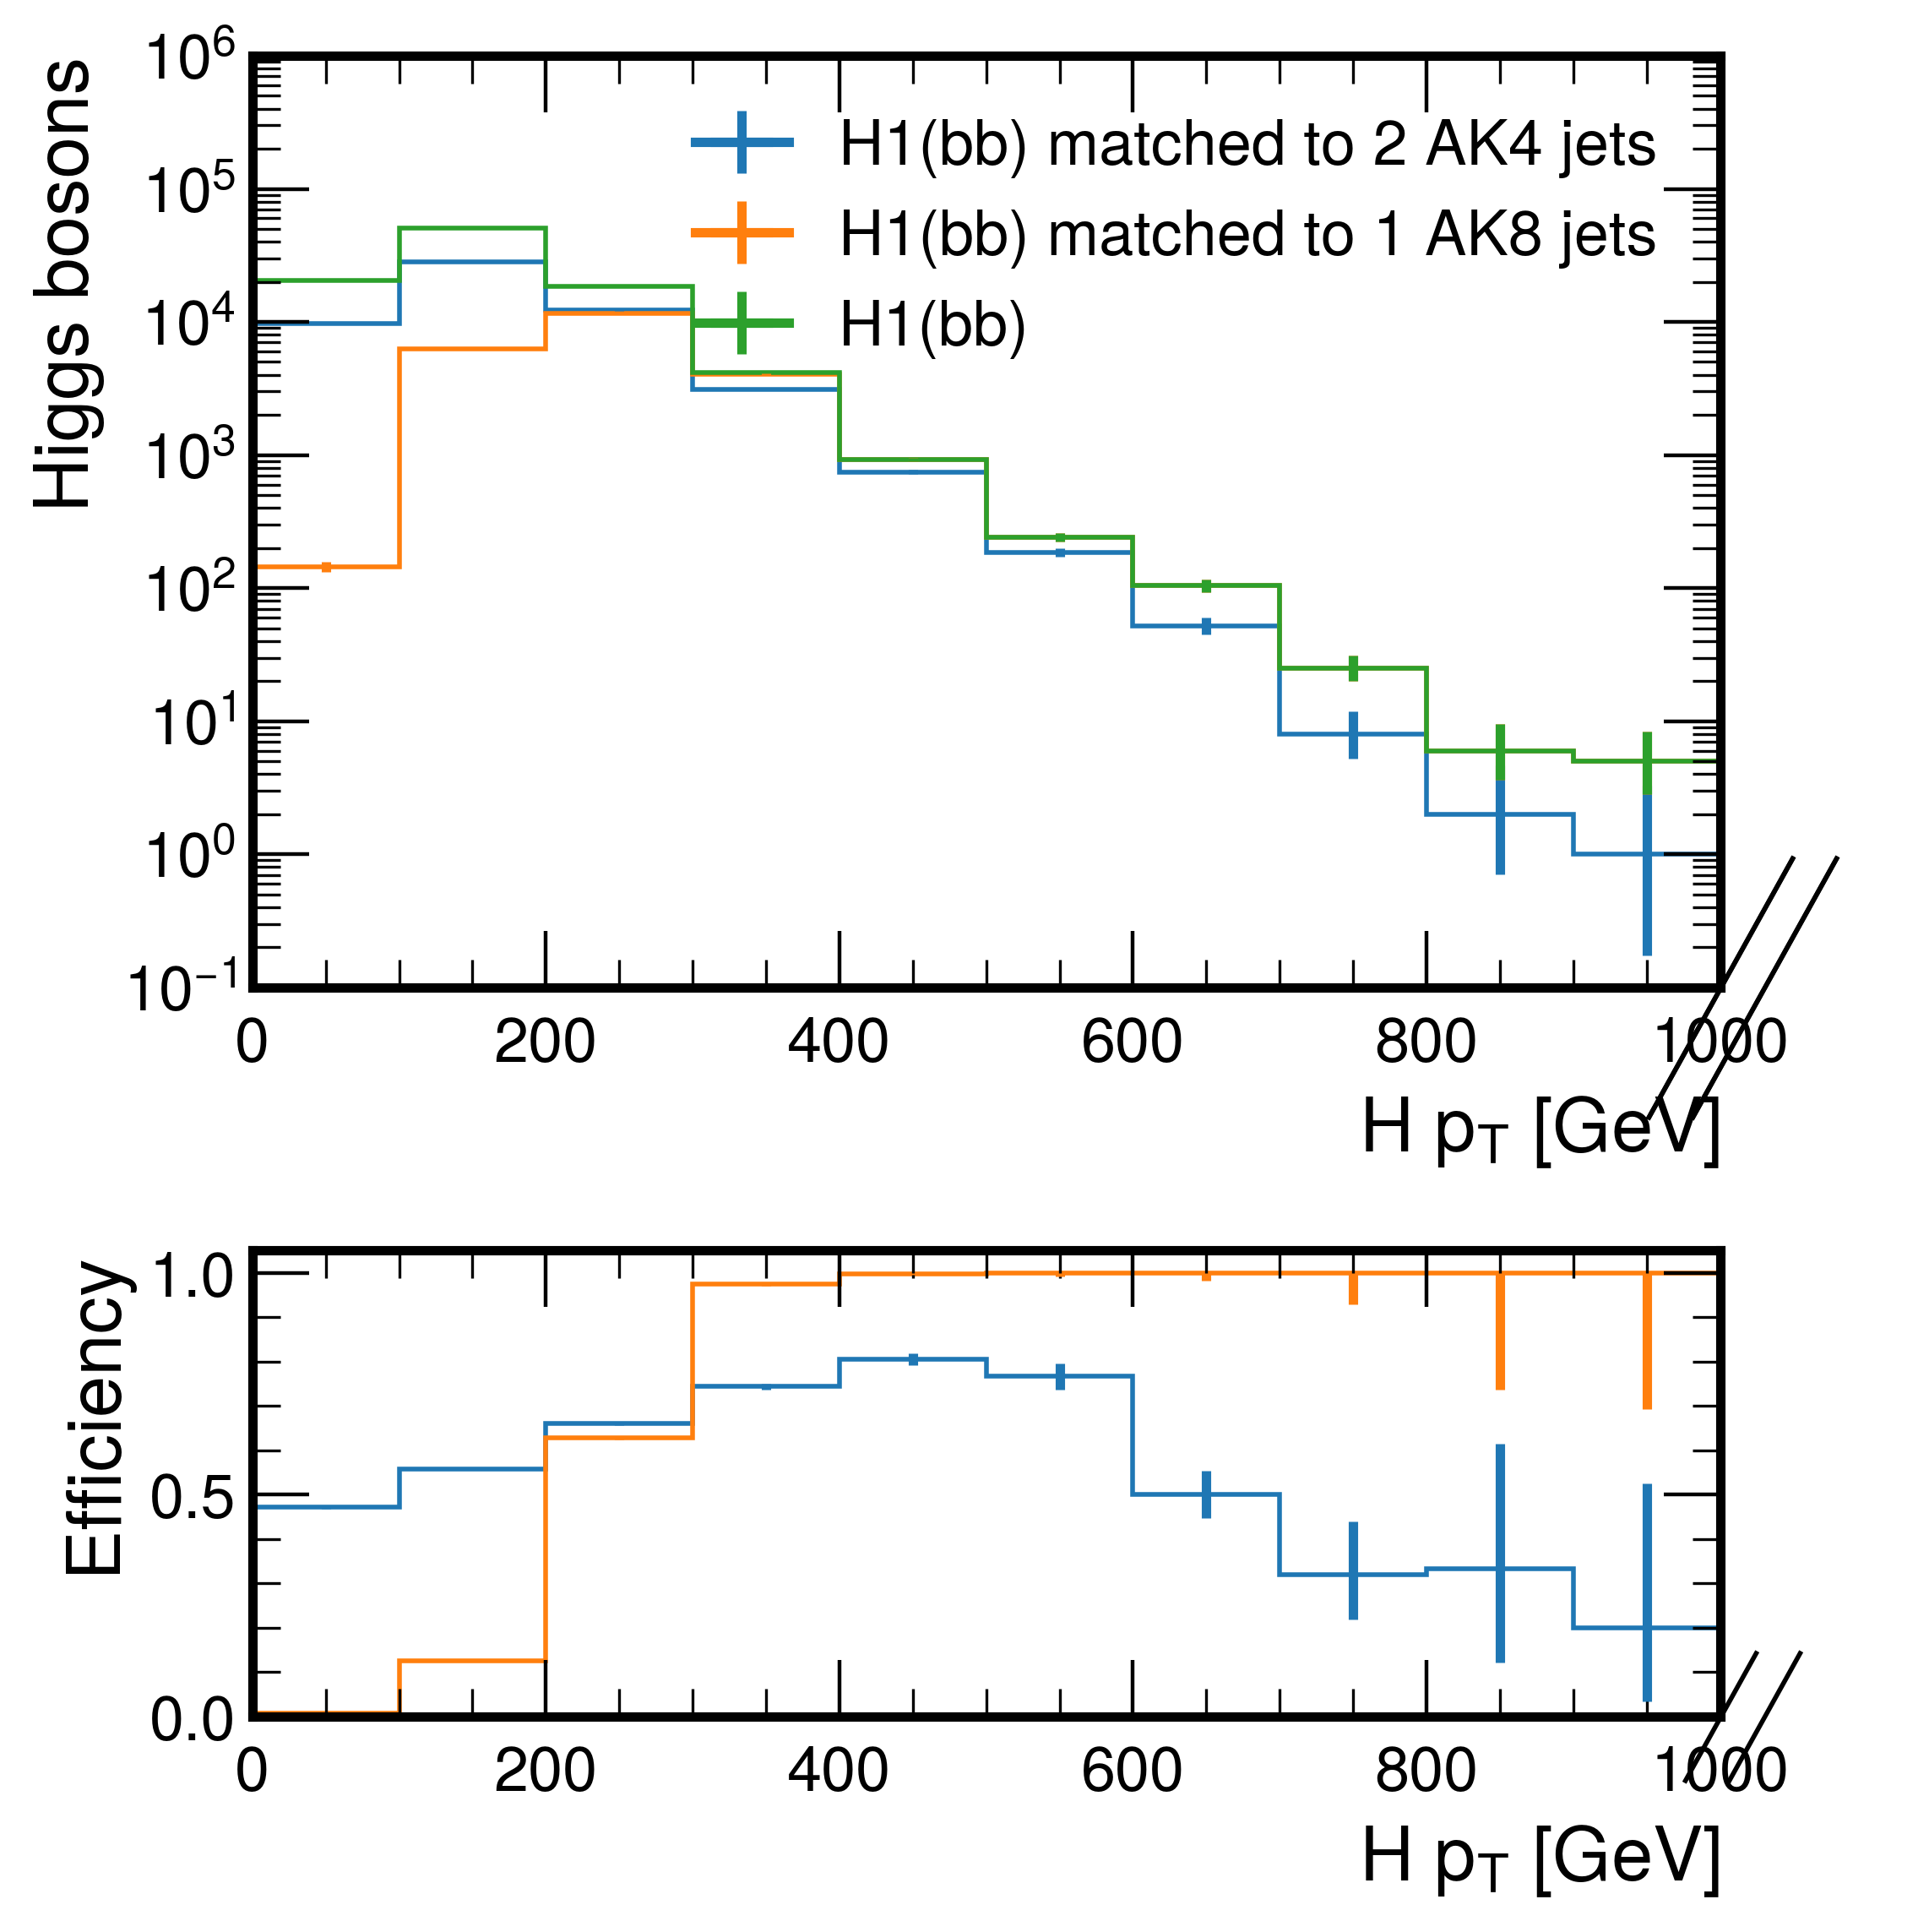

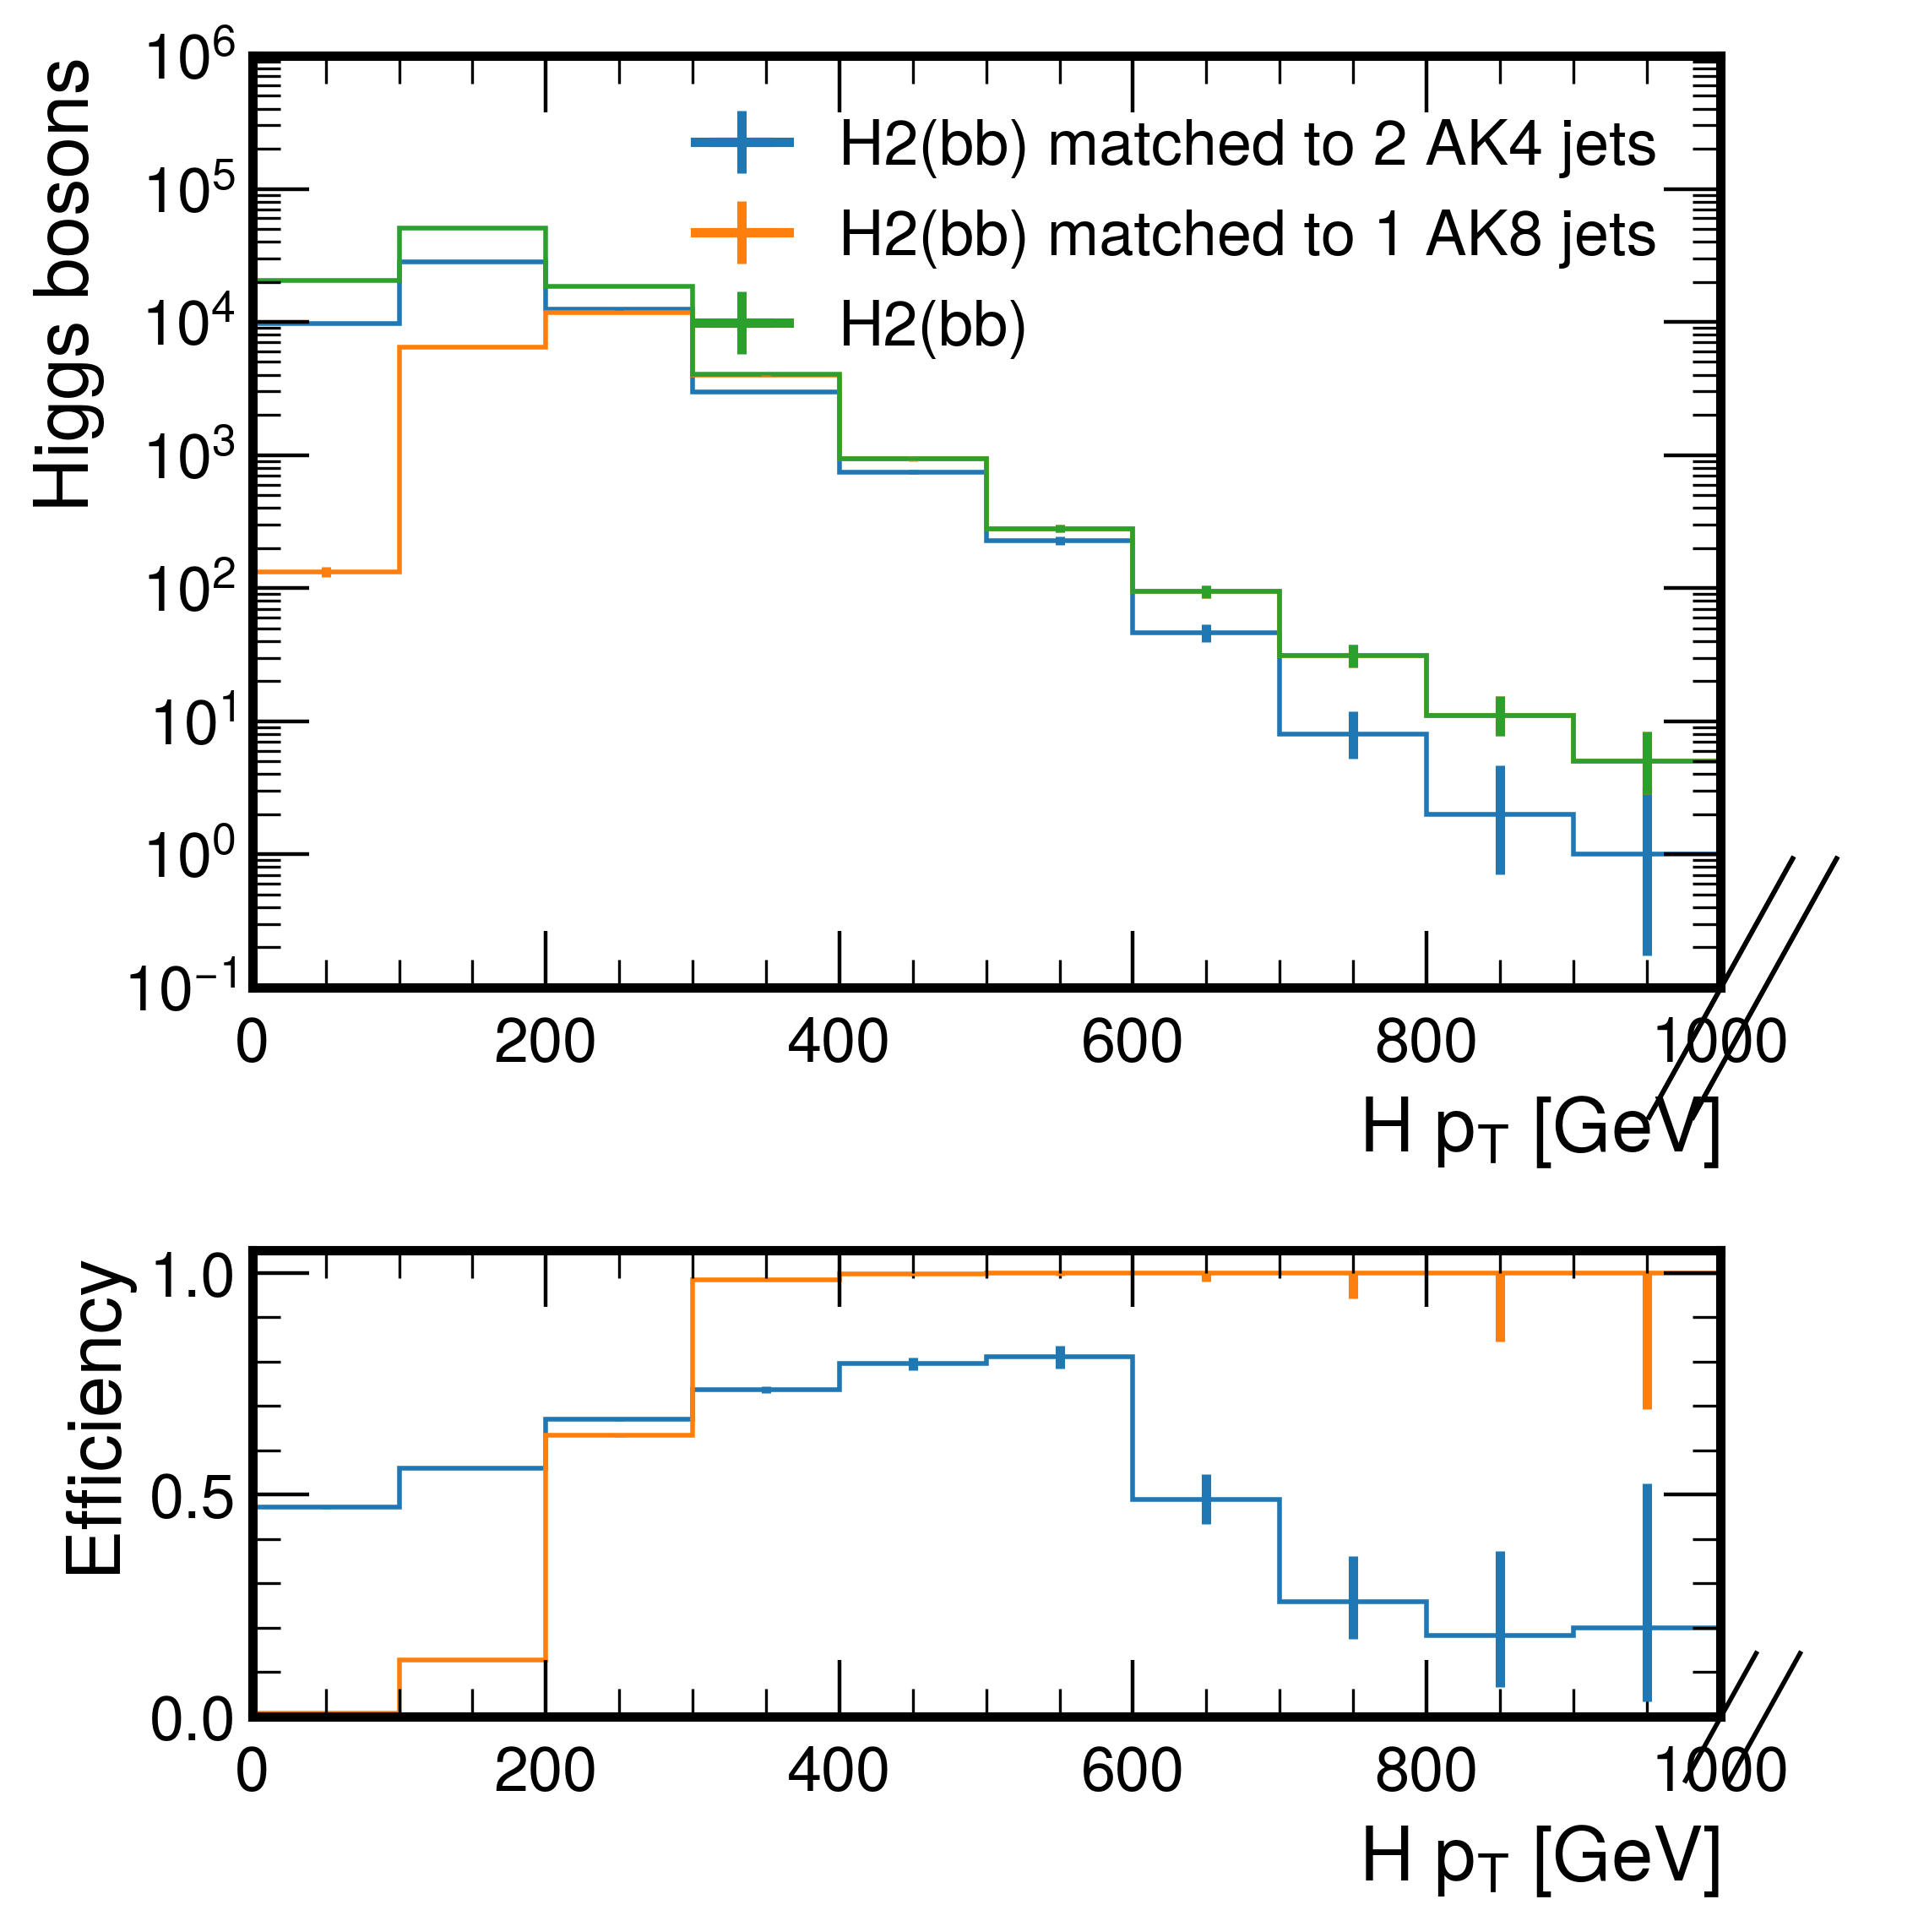

In [25]:
N_bin = 10

for h_index in range(2):
    higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
    higgs_pt.fill(gen_higgs[:, h_index].pt)

    if h_index == 0:
        h_mwfj = h1_mwfj.pt
        h_mwj = h1_mwj.pt
    else:
        h_mwfj = h2_mwfj.pt
        h_mwj = h2_mwj.pt

    fj_higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
    fj_higgs_pt.fill(h_mwfj)

    j_higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
    j_higgs_pt.fill(h_mwj)

    j_ratio = j_higgs_pt / higgs_pt
    j_ratio_h1 = j_ratio
    j_ratio_uncert = np.abs(
        clopper_pearson_interval(num=j_higgs_pt.values(), denom=higgs_pt.values()) - j_ratio
    )
    fj_ratio = fj_higgs_pt / higgs_pt
    fj_ratio_uncert = np.abs(
        clopper_pearson_interval(num=fj_higgs_pt.values(), denom=higgs_pt.values()) - fj_ratio
    )

    fig, axs = plt.subplots(2, 1, height_ratios=[2, 1], figsize=(6, 6))
    hep.histplot(j_higgs_pt, label=f"H{h_index+1}(bb) matched to 2 AK4 jets", ax=axs[0])
    hep.histplot(fj_higgs_pt, label=f"H{h_index+1}(bb) matched to 1 AK8 jets", ax=axs[0])
    hep.histplot(higgs_pt, label=f"H{h_index+1}(bb)", ax=axs[0])
    axs[0].set_ylabel("Higgs bosons")
    axs[0].set_xlim(0, 1000)
    axs[0].set_ylim(1e-1, 1e6)
    axs[0].semilogy()
    axs[0].legend(loc="upper right")
    hep.histplot(
        j_ratio,
        yerr=j_ratio_uncert,
        label="H(bb) matched to 2 AK4 jets",
        ax=axs[1],
    )
    hep.histplot(
        fj_ratio,
        yerr=fj_ratio_uncert,
        label="H(bb) matched to 1 AK8 jets",
        ax=axs[1],
    )
    axs[1].set_ylabel("Efficiency")
    axs[1].set_xlim(0, 1000)
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/matching_eff_H{h_index+1}.jpg")